In [ ]:
# 必要なライブラリをインストール
# !pip install astroquery astropy matplotlib Pillow reproject ipywidgets

import os
import re
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from astroquery.astrometry_net import AstrometryNet
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from reproject import reproject_interp
import ipywidgets as widgets
from IPython.display import display
import io
import tempfile
import subprocess
import urllib.request
import csv

# ファイルアップロード用のウィジェットとステータス表示エリア
upload_status = widgets.Output()

uploader = widgets.FileUpload(
    accept='.fits, .fit, .jpg, .jpeg, .png',
    multiple=False,
    description='画像ファイルを選択',
    button_style='primary'
)

def on_upload_change(change):
    """ファイルが選択されたら、ボタンの色とメッセージを更新する"""
    if not change.new:
        # ファイル選択がキャンセルされた場合
        return
        
    # ボタンの色を成功を示す緑色に変更
    uploader.button_style = 'success'
    
    # アップロードされたファイル名を取得
    uploaded_filename = change.new[0]['name']

    # Outputウィジェットをクリアしてから新しいメッセージを表示
    with upload_status:
        upload_status.clear_output(wait=True)
        print(f"✅ ファイル選択完了: {uploaded_filename}")

# ウィジェットの動作を監視
uploader.observe(on_upload_change, names='value')

# ウィジェットを表示
display(widgets.VBox([uploader, upload_status]))
print("\nファイルを選択したら、次のセルを実行してください。")


ファイルを選択したら、次のセルを実行してください。



✅ ファイル 'Capture_00001 00_10_33.fits' を処理します。
--------------------------------------------------
🌍 オンライン 環境で実行します。
--------------------------------------------------

SIMBADで 'UCAC4 660-021020' の座標を検索しています...
-> SIMBADでの座標を特定: 04h07m38.878464s +41d59m10.59324s
-> Gaia DR3カタログとクロス（相互）マッチング中...
✅ Gaia DR3の高精度座標が見つかりました: RA=61.911992°

FITSファイルを読み込み中...

[優先処理] オンラインAPIで解析を試みます...
Solving.............✅ オンライン解析成功！

元の画像をプロットします...


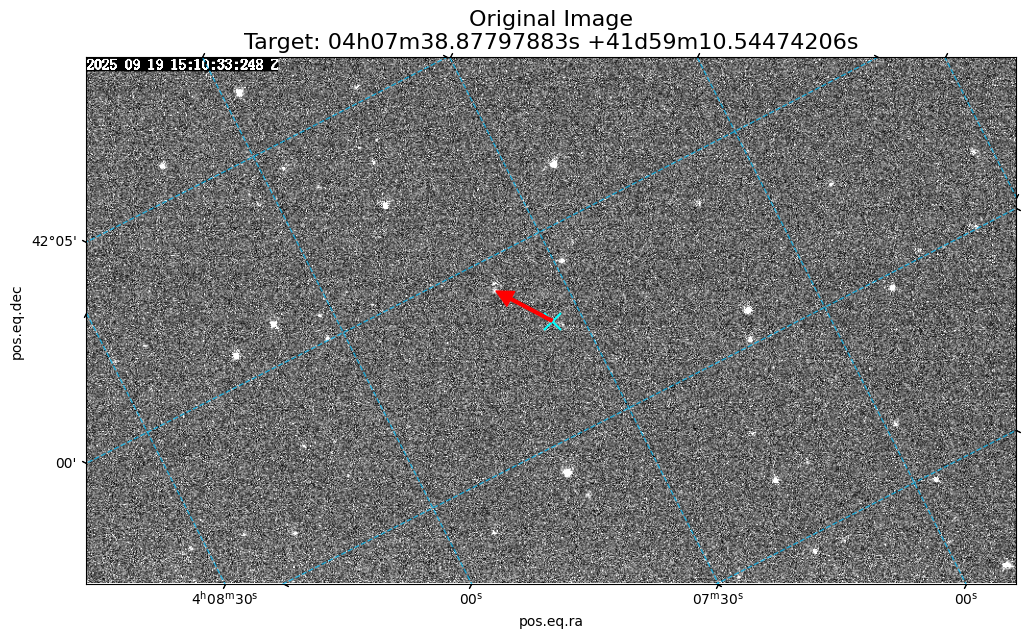


北を上にして回転させた画像をプロットします...



✅ 画像中心から目標までの距離詳細:
   - 全角距離:       1.606 分角
   - 赤経(RA) 方向:  0.920 分角 (東へ)
   - 赤緯(Dec)方向:  1.316 分角 (北へ)


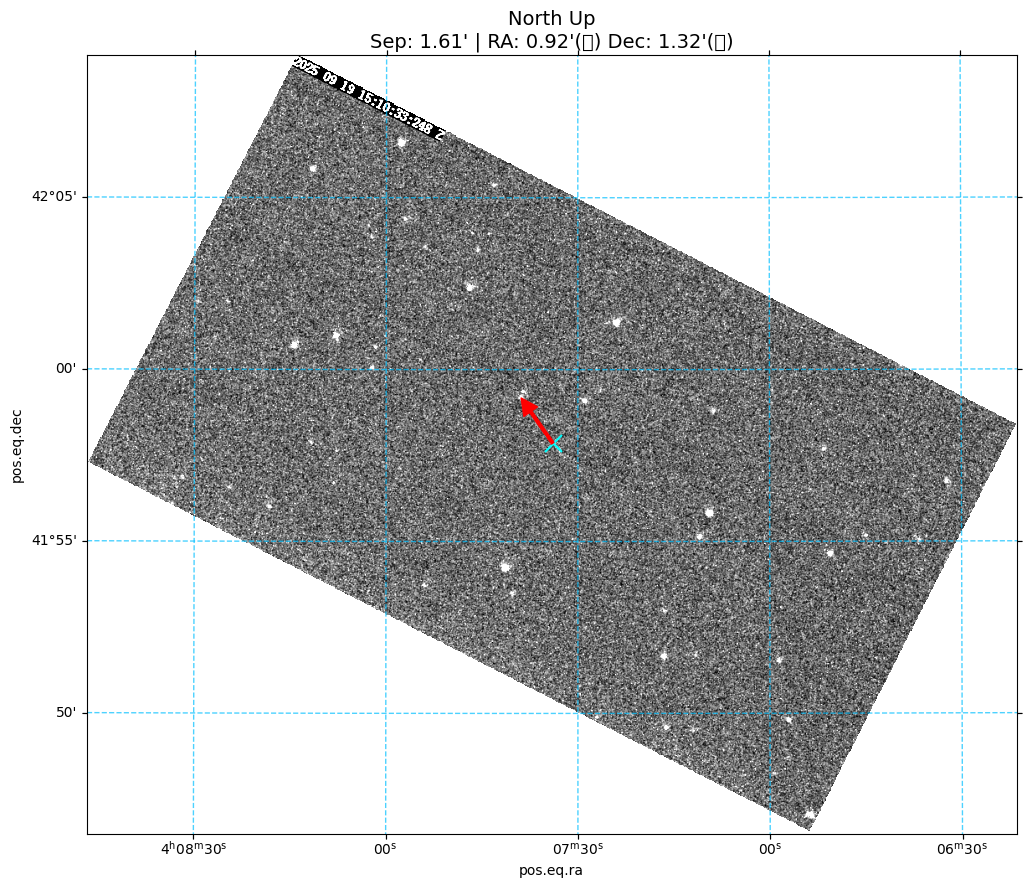

In [ ]:
# ==============================================================================
# --- ユーザー設定項目 ---
# ==============================================================================
# 1. 既存のWCS情報を無視して新規解析するか (True推奨)
IGNORE_EXISTING_WCS = True

# 2. タイムアウト設定 (秒)
ONLINE_TIMEOUT = 120    # オンライン解析の強制打ち切り時間
OFFLINE_TIMEOUT = 300   # オフライン(WSL)解析の最大時間

# 3. 目標の指定方法を選択 ('COORDS' または 'STAR_NAME')
# ※ オフライン時は 'COORDS' のみ動作します
INPUT_MODE = 'STAR_NAME'

# 4a. 座標で指定する場合 (INPUT_MODE = 'COORDS')
RA_INPUT_STR = "04h 07m 38.877s"
DEC_INPUT_STR = "+41d 59m 10.512s"
# 4b. 恒星名で指定する場合 (INPUT_MODE = 'STAR_NAME')
# ※ オンライン時のみ有効
TARGET_STAR_NAME = 'UCAC4 660-021020'

# 5. Astrometry.net APIキー
API_KEY = "axvhxwfkvnzreobn"
# ==============================================================================

import concurrent.futures
import time

def check_internet_connection(timeout=2):
    """インターネット接続チェック"""
    try:
        urllib.request.urlopen('http://www.google.com', timeout=timeout)
        return True
    except:
        return False

def convert_to_safe_png(input_path):
    """WSL解析用: FITSをPNGに変換"""
    try:
        if input_path.lower().endswith(('.fits', '.fit')):
            with fits.open(input_path) as hdul:
                data = hdul[0].data
                if data is None: data = hdul[1].data
        else:
            with Image.open(input_path) as img:
                data = np.array(img.convert('L'))

        data = np.nan_to_num(data)
        vmin, vmax = np.percentile(data, [1, 99])
        data_norm = (data - vmin) / (vmax - vmin)
        data_norm = np.clip(data_norm, 0, 1)
        data_8bit = (data_norm * 255).astype(np.uint8)

        png_path = os.path.splitext(input_path)[0] + "_solver.png"
        Image.fromarray(data_8bit).save(png_path)
        print(f"-> 解析用に画像を変換しました: {os.path.basename(png_path)}")
        return png_path
    except Exception as e:
        print(f"❌ 画像変換エラー: {e}")
        return None

def solve_image_with_wsl(windows_image_path, timeout=OFFLINE_TIMEOUT):
    """WSLを使用したオフライン解析"""
    print("\n[WSL] Astrometry.net解析準備...")
    safe_image_path = convert_to_safe_png(windows_image_path)
    if not safe_image_path: return None

    try:
        path_no_drive = safe_image_path.split(':', 1)[1]
        drive_letter = safe_image_path[0].lower()
        wsl_path = f"/mnt/{drive_letter}{path_no_drive.replace(os.path.sep, '/')}"
    except IndexError:
        print(f"エラー: パス変換失敗: {safe_image_path}")
        return None

    base = os.path.splitext(safe_image_path)[0]
    expected_wcs_path = base + ".wcs"
    if os.path.exists(expected_wcs_path):
        try: os.remove(expected_wcs_path)
        except: pass

    print(f"[WSL] 解析を開始します (最大 {timeout} 秒)...")
    
    command = [
        'wsl', 'solve-field', wsl_path,
        '--overwrite',
        '--no-plots',
        '--cpulimit', str(timeout),
        '--scale-units', 'arcsecperpix',
        '--scale-low', '0.1',
        '--scale-high', '5.0'
    ]
    
    try:
        process = subprocess.run(
            command, capture_output=True, text=True, encoding='utf-8', timeout=timeout + 10
        )
    except subprocess.TimeoutExpired:
        print(f"\n❌ [WSL] タイムアウト: {timeout}秒を超えました。")
        return None

    if process.returncode == 0:
        if "Field 1 solved" in process.stdout or os.path.exists(expected_wcs_path):
            print("✅ [WSL] 解析に成功しました！")
            if os.path.exists(expected_wcs_path):
                try: return fits.getheader(expected_wcs_path)
                except: return None
        else:
            print("❌ [WSL] 解析完了しましたが、解決できませんでした。")
            if "simplexy: found" in process.stdout:
                for line in process.stdout.splitlines():
                    if "simplexy: found" in line: print(f"  参考: {line.strip()}")
    else:
        print("❌ [WSL] 実行エラーが発生しました。")
    return None

def get_coords_from_simbad(star_name):
    print(f"\nSIMBADで '{star_name}' の座標を検索しています...")
    try:
        simbad_coord = SkyCoord.from_name(star_name)
        print(f"-> SIMBADでの座標を特定: {simbad_coord.to_string('hmsdms')}")
        print("-> Gaia DR3カタログとクロス（相互）マッチング中...")
        v_gaia = Vizier(catalog="I/355/gaiadr3", columns=['RA_ICRS', 'DE_ICRS'])
        gaia_result = v_gaia.query_region(simbad_coord, radius=5 * u.arcsec)
        if not gaia_result or len(gaia_result) == 0:
            return simbad_coord.ra.deg, simbad_coord.dec.deg
        print(f"✅ Gaia DR3の高精度座標が見つかりました: RA={gaia_result[0][0]['RA_ICRS']:.6f}°")
        return gaia_result[0][0]['RA_ICRS'], gaia_result[0][0]['DE_ICRS']
    except Exception as e:
        print(f"❌ エラー: 座標検索失敗: {e}")
        return None, None

def parse_ra_dec_input(ra_input, dec_input):
    coord = SkyCoord(ra_input, dec_input, frame='icrs')
    return coord.ra.deg, coord.dec.deg

def clip_arrow_to_boundary(start_x, start_y, end_x, end_y, x_lim, y_lim):
    xmin, xmax = min(x_lim), max(x_lim)
    ymin, ymax = min(y_lim), max(y_lim)
    if xmin <= end_x <= xmax and ymin <= end_y <= ymax: return end_x, end_y
    dx, dy = end_x - start_x, end_y - start_y
    if dx == 0 and dy == 0: return end_x, end_y
    t_values = []
    if abs(dx) > 1e-9: t_values.extend([(xmin - start_x) / dx, (xmax - start_x) / dx])
    if abs(dy) > 1e-9: t_values.extend([(ymin - start_y) / dy, (ymax - start_y) / dy])
    min_t = float('inf')
    for t in t_values:
        if t > 1e-9:
            ix, iy = start_x + t * dx, start_y + t * dy
            if (xmin - 1e-6) <= ix <= (xmax + 1e-6) and (ymin - 1e-6) <= iy <= (ymax + 1e-6):
                if t < min_t: min_t = t
    if min_t != float('inf'): return start_x + min_t * 0.99 * dx, start_y + min_t * 0.99 * dy
    return end_x, end_y

def plot_original_image(wcs_header, data, ra_target, dec_target):
    print("\n元の画像をプロットします...")
    if 'SIMPLE' not in wcs_header: wcs_header['SIMPLE'] = True
    wcs = WCS(wcs_header)
    ny, nx = data.shape
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection=wcs)
    data_safe = np.nan_to_num(data)
    vmin, vmax = np.percentile(data_safe, 1), np.percentile(data_safe, 99)
    ax.imshow(data, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
    ax.set_xlim(-0.5, nx - 0.5); ax.set_ylim(-0.5, ny - 0.5); ax.invert_yaxis()
    ax.coords.grid(color='deepskyblue', linestyle='--', linewidth=1.0, alpha=0.7)
    
    center_coord = wcs.pixel_to_world(nx / 2.0, ny / 2.0)
    target_coord = SkyCoord(ra=ra_target*u.deg, dec=dec_target*u.deg, frame='fk5')
    sx, sy = wcs.world_to_pixel(center_coord)
    try:
        tx, ty = wcs.world_to_pixel(target_coord)
        if not np.all(np.isfinite([tx, ty])): raise ValueError
    except:
        pa = center_coord.position_angle(target_coord)
        near = center_coord.directional_offset_by(pa, 1 * u.arcsec)
        nxn, nyn = wcs.world_to_pixel(near)
        tx, ty = sx + (nxn - sx) * 1e6, sy + (nyn - sy) * 1e6
    
    cx, cy = clip_arrow_to_boundary(sx, sy, tx, ty, ax.get_xlim(), ax.get_ylim())
    ax.scatter(sx, sy, color='cyan', marker='x', s=150)
    ax.annotate('', xy=(cx, cy), xytext=(sx, sy), arrowprops=dict(facecolor='red', edgecolor='red', width=2))
    ax.set_title(f'Original Image\nTarget: {target_coord.to_string("hmsdms")}', size=16)
    plt.show()

def plot_reprojected_image_full(wcs_header, data, ra_target, dec_target):
    print("\n北を上にして回転させた画像をプロットします...")
    if 'SIMPLE' not in wcs_header: wcs_header['SIMPLE'] = True
    wcs = WCS(wcs_header)
    ny, nx = data.shape
    wcs_no_rot = WCS(naxis=2)
    center = wcs.pixel_to_world(nx/2, ny/2)
    wcs_no_rot.wcs.crval = [center.ra.deg, center.dec.deg]
    wcs_no_rot.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    try: scale = np.sqrt(np.abs(np.linalg.det(wcs.wcs.cd)))
    except: scale = 0.00027
    wcs_no_rot.wcs.cdelt = np.array([-scale, scale])
    corners = wcs.pixel_to_world([0, nx, 0, nx], [0, 0, ny, ny])
    new_pix = wcs_no_rot.world_to_pixel(corners)
    wcs_no_rot.wcs.crpix = [-np.min(new_pix[0]), -np.min(new_pix[1])]
    shape_out = (int(np.ceil(np.max(new_pix[1]) - np.min(new_pix[1]))), int(np.ceil(np.max(new_pix[0]) - np.min(new_pix[0]))))
    
    data_rep, fp = reproject_interp((data, wcs), wcs_no_rot, shape_out=shape_out)
    data_rep[fp == 0] = np.nan
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection=wcs_no_rot)
    valid = np.nan_to_num(data_rep)[fp!=0]
    vmax = np.percentile(valid, 99) if len(valid) > 0 else 255
    ax.imshow(data_rep, origin='lower', cmap='gray', vmin=np.percentile(valid, 1) if len(valid)>0 else 0, vmax=vmax)
    ax.coords.grid(color='deepskyblue', linestyle='--', linewidth=1.0, alpha=0.7)
    
    target = SkyCoord(ra=ra_target*u.deg, dec=dec_target*u.deg, frame='fk5')
    
    # 1. 全角距離
    separation_arcmin = center.separation(target).arcmin
    
    # 2. 赤経・赤緯方向のオフセット計算 (spherical_offsets_toを使用)
    d_ra, d_dec = center.spherical_offsets_to(target)
    d_ra_val = d_ra.to(u.arcmin).value
    d_dec_val = d_dec.to(u.arcmin).value
    
    ra_dir = "東" if d_ra_val > 0 else "西"
    dec_dir = "北" if d_dec_val > 0 else "南"
    
    print(f"\n✅ 画像中心から目標までの距離詳細:")
    print(f"   - 全角距離:       {separation_arcmin:.3f} 分角")
    print(f"   - 赤経(RA) 方向:  {abs(d_ra_val):.3f} 分角 ({ra_dir}へ)")
    print(f"   - 赤緯(Dec)方向:  {abs(d_dec_val):.3f} 分角 ({dec_dir}へ)")

    sx, sy = wcs_no_rot.world_to_pixel(center)
    try: tx, ty = wcs_no_rot.world_to_pixel(target)
    except: tx, ty = sx, sy
    cx, cy = clip_arrow_to_boundary(sx, sy, tx, ty, ax.get_xlim(), ax.get_ylim())
    ax.scatter(sx, sy, color='cyan', marker='x', s=150)
    ax.annotate('', xy=(cx, cy), xytext=(sx, sy), arrowprops=dict(facecolor='red', edgecolor='red', width=2))
    
    title_text = (f'North Up\n'
                  f'Sep: {separation_arcmin:.2f}\' | '
                  f'RA: {abs(d_ra_val):.2f}\'({ra_dir}) '
                  f'Dec: {abs(d_dec_val):.2f}\'({dec_dir})')
    ax.set_title(title_text, size=14)
    plt.show()

if __name__ == '__main__':
    if not uploader.value:
        print("\n⚠️ 画像ファイルが選択されていません。")
    else:
        uploaded_file = uploader.value[0]
        file_name = uploaded_file['name']
        with tempfile.NamedTemporaryFile(delete=False, suffix=os.path.splitext(file_name)[1]) as temp_file:
            temp_file.write(uploaded_file['content'])
            IMG_FILEPATH = temp_file.name
        
        print(f"\n✅ ファイル '{file_name}' を処理します。")
        is_online = check_internet_connection()
        ra_target, dec_target = None, None
        print("-" * 50)
        print("🌍 オンライン" if is_online else "🔌 オフライン", "環境で実行します。")
        print("-" * 50)

        # 座標取得
        if INPUT_MODE == 'STAR_NAME':
            if TARGET_STAR_NAME:
                if is_online:
                    ra_target, dec_target = get_coords_from_simbad(TARGET_STAR_NAME)
                else:
                    print(f"\n❌ オフラインのため、恒星名検索はスキップします。")
                    print("   (オンラインAPIも使用不可のため、WSL解析後に矢印表示はできません)")
            else:
                print("エラー: 恒星名未設定")
        elif INPUT_MODE == 'COORDS':
            ra_target, dec_target = parse_ra_dec_input(RA_INPUT_STR, DEC_INPUT_STR)
        
        # 解析開始
        wcs_header, image_data = None, None
        if IMG_FILEPATH.lower().endswith(('.fits', '.fit')):
            print("\nFITSファイルを読み込み中...")
            with fits.open(IMG_FILEPATH) as hdul:
                image_data = hdul[0].data
                if not IGNORE_EXISTING_WCS:
                    try:
                        wcs = WCS(hdul[0].header)
                        if wcs.is_celestial:
                            print("✅ 既存WCS情報を読み込みました。")
                            wcs_header = hdul[0].header
                    except: pass

        if wcs_header is None:
            if image_data is None: 
                with Image.open(IMG_FILEPATH) as img:
                    image_data = np.array(img.convert('L'))
            
            # オンライン解析を別スレッドで実行し、厳密にタイムアウトさせる
            if is_online:
                print("\n[優先処理] オンラインAPIで解析を試みます...")
                try:
                    ast = AstrometryNet()
                    ast.api_key = API_KEY
                    
                    # 別スレッドで実行して時間を監視する
                    with concurrent.futures.ThreadPoolExecutor() as executor:
                        future = executor.submit(ast.solve_from_image, IMG_FILEPATH, solve_timeout=ONLINE_TIMEOUT)
                        wcs_header = future.result(timeout=ONLINE_TIMEOUT)
                        
                    if wcs_header:
                        print("✅ オンライン解析成功！")
                    else:
                        raise Exception("API returned None")
                        
                except (concurrent.futures.TimeoutError, Exception) as e:
                    print(f"⚠️ オンライン解析失敗またはタイムアウト({ONLINE_TIMEOUT}秒)。")
                    print(f"   理由: {e}")
                    print("   -> ローカルWSLへ切り替えます。")
                    wcs_header = solve_image_with_wsl(IMG_FILEPATH, OFFLINE_TIMEOUT)
            else:
                print("\n[ローカルWSL] で解析します。")
                wcs_header = solve_image_with_wsl(IMG_FILEPATH, OFFLINE_TIMEOUT)

        if wcs_header:
            if ra_target is not None:
                plot_original_image(wcs_header, image_data, ra_target, dec_target)
                plot_reprojected_image_full(wcs_header, image_data, ra_target, dec_target)
            else:
                print("✅ 解析成功（目標座標がないためプロットはスキップしました）")
        else:
            print("\n❌ 解析失敗：WCS情報を取得できませんでした。")